# **Taxi Trip Duration Prediction in New York City: A Comparative Analysis of Machine Learning Models**

Taxi transportation in New York City, United States, plays an important role in meeting the mobility needs of both residents and tourists. Several advantages make taxis a preferred choice, such as easy accessibility, comfort, and short travel times. In this context, predicting taxi trip duration is crucial to improving service efficiency and fleet management. This study aims to analyze and compare six taxi trip duration prediction models, including Random Forest, XGBoost, Neural Network, Generalized Linear Model, Support Vector Regression, and Ridge and Lasso regression. Through evaluation, this study seeks to determine the best model that can be adopted by the taxi industry in New York City. By providing concrete solutions and recommendations, this research is expected to serve as a valuable guide for taxi companies in enhancing their services and optimizing their fleet operations.

## 1. Dataset Description

The [dataset](https://www.kaggle.com/competitions/nyc-taxi-trip-duration) used in this study was obtained from the Kaggle website. The dataset consists of yellow taxi trip records in New York, United States, for the year 2016. The data was published by the NYC Taxi and Limousine Commission (TLC).

The dataset is divided into training and testing data. The training data contains 1,458,644 trip records, while the testing data consists of 625,134 trip records. The taxi trip time data includes 9 variables: id, vendor_id, pickup_datetime, dropoff_datetime, passenger_count, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, store_and_fwd_flag, and trip_duration.

In [ ]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2

In [ ]:
df = pd.read_csv("/kaggle/input/nyc-taxi-trip-duration/train.zip")
df.head()
df.shape

(1458644, 11)

## 2. Exploratory Data Analysis and Pre-rocessing


**Data pre-processing** is a technique used to prepare data for further processing in order to extract knowledge. The data pre-processing in this report includes the following steps:

1. Creating a new variable **distance** that calculates the distance between the variables `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, and `dropoff_latitude` in kilometers.
2. Creating two new variables related to **rush_hour**, which are **rush_hour_rush** and **rush_hour_normal**. These are assigned a value of 1 if the taxi trip takes place between 7:00 to 10:00 AM and 4:00 to 7:00 PM for **rush_hour_rush**, and 1 for **rush_hour_normal** if the trip occurs between 10:00 AM to 4:00 PM, with a value of 0 for any other times.
3. Creating a **weekday/weekend** variable, which is assigned a value of 1 if the trip occurs on a weekday and 0 if on the weekend.

After creating the new variables, a number of outlier observations were identified based on the data distribution in the boxplot. Taxi trip distances between pickup and dropoff points are filtered to a maximum of 200 km, as some observations had distances exceeding 600 km, which are unreasonable for a taxi trip. Additionally, observations with trip durations exceeding 4 hours will be filtered out. Finally, observations with a passenger count of 0 will also be removed.



In [ ]:
def haversine_distance(row):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1 = radians(row['pickup_latitude']), radians(row['pickup_longitude'])
    lat2, lon2 = radians(row['dropoff_latitude']), radians(row['dropoff_longitude'])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    radius_of_earth = 6371  # Earth's radius in kilometers
    distance = radius_of_earth * c

    return distance

<Axes: >

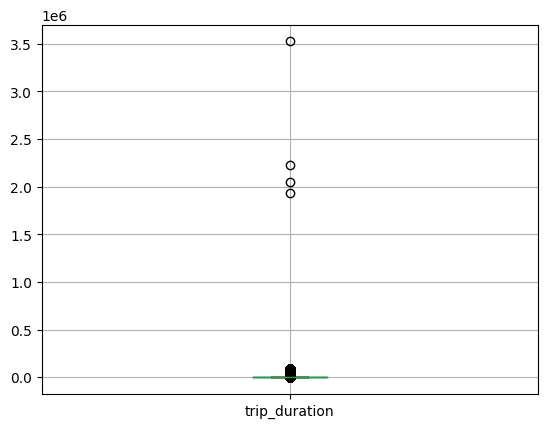

In [ ]:
df[['trip_duration']].boxplot()

<Axes: >

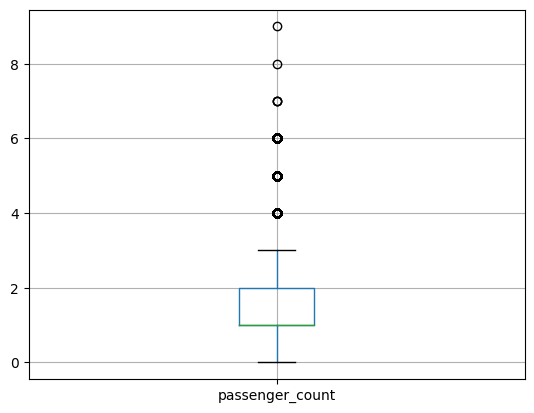

In [ ]:
df[['passenger_count']].boxplot()

In [ ]:
df = df[df['trip_duration']<14400] #durasi taksi dibataskan 4 jam
df = df[df['passenger_count']>0] #taksi minimal pickup 1 orang


df['distance'] = df.apply(haversine_distance, axis=1)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['rush_nonrush'] = df['pickup_datetime'].dt.hour.apply(lambda x: 'rush' if 7 <= x <= 10 or 16 <= x <= 19 else 'nonrush')
df['weekday_weekend'] = df['pickup_datetime'].dt.dayofweek.apply(lambda x: 'weekday' if x < 5 else 'weekend')
df_encoded = pd.get_dummies(df, columns=['rush_nonrush', 'weekday_weekend'])

# Ubah ke biner
df_encoded['rush_nonrush'] = df_encoded['rush_nonrush_rush'].astype(int)
df_encoded['weekday_weekend'] = df_encoded['weekday_weekend_weekday'].astype(int)
df_encoded = df_encoded.drop(['rush_nonrush_rush', 'rush_nonrush_nonrush', 'weekday_weekend_weekday', 'weekday_weekend_weekend'], axis=1)

df = df_encoded
df.drop(columns=['vendor_id','id','pickup_datetime','dropoff_datetime','store_and_fwd_flag','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], inplace=True, axis=1)
df = df[df['distance']<200]
df.head()

,passenger_count,trip_duration,distance,rush_nonrush,weekday_weekend
0,1,455,1.498521,1,1
1,1,663,1.805507,0,0
2,1,2124,6.385098,0,1
3,1,429,1.485498,1,1
4,1,435,1.188588,0,0


<Axes: >

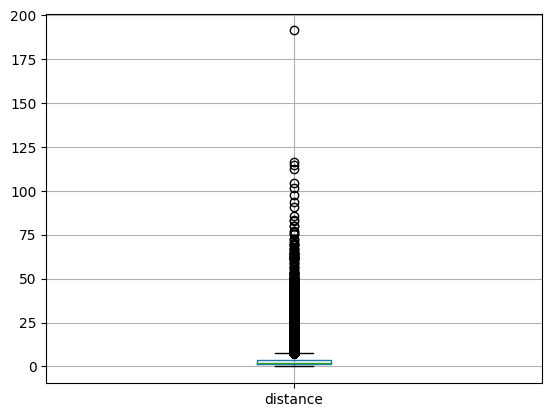

In [ ]:
df[['distance']].boxplot()

<Axes: >

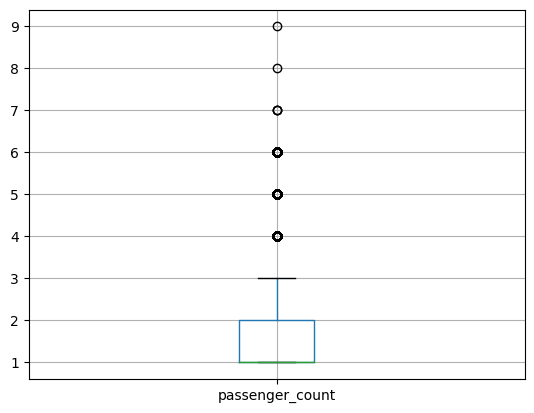

In [ ]:
df[['passenger_count']].boxplot()

<Axes: >

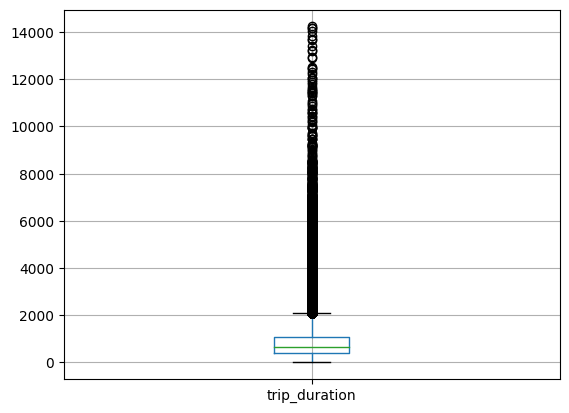

In [ ]:
df[['trip_duration']].boxplot()

## 3. Data splitting into training and testing

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

column_to_scale = df['trip_duration'].values.reshape(-1, 1)

scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()

scaled_df = pd.DataFrame(scaler1.fit_transform(df), columns=df.columns)
scaler2.fit(column_to_scale)

scaled_df.head()

,passenger_count,trip_duration,distance,rush_nonrush,weekday_weekend
0,0.0,0.031878,0.007829,1.0,1.0
1,0.0,0.046482,0.009433,0.0,0.0
2,0.0,0.149066,0.033359,0.0,1.0
3,0.0,0.030052,0.007761,1.0,1.0
4,0.0,0.030473,0.006210,0.0,0.0


In [ ]:
X = df.drop(columns=['trip_duration'])
y = df[['trip_duration']]

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable

# Splitting X and y into training and testing sets (using 80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

# Print the shapes of the resulting sets to verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1165197, 4)
X_test shape: (291300, 4)
y_train shape: (1165197, 1)
y_test shape: (291300, 1)


## 4. Model testing and training

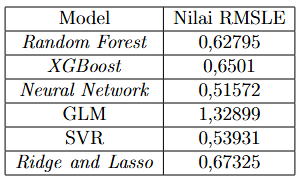


From Table above, it can be observed that the GLM method is not suitable for modeling the data because the selected independent variables include both categorical and numerical variables. The Random Forest method produces better results compared to XGBoost, which may be due to the XGBoost model overfitting the data. Furthermore, the results obtained from the Ridge and Lasso methods are not satisfactory, as the selected independent variables are only significant variables. The SVR model achieves a relatively low RMSLE value because SVR is known to perform well when handling large datasets. Finally, the Neural Network model achieves the lowest RMSLE value, making it the best method among the five for modeling the data. The Neural Network method is considered the most effective because it is a deep learning approach, which provides higher accuracy. However, it also has a drawback, as it requires a relatively long computation time, making it less efficient than other methods.

### 4.1 Training and testing with Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

model = Sequential()

# Add layers to the model
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu'))  # Adjust input_shape accordingly
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')  # Using mean squared error for regression

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               1280      
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17793 (69.50 KB)
Trainable params: 17793 (69.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, epochs=5, batch_size=256, validation_split=0.2)  # Adjust epochs, batch_size, and validation_split

Epoch 1/5
3642/3642 [==============================] - 12s 3ms/step - loss: 208097.5625 - val_loss: 174922.6719
Epoch 2/5
3642/3642 [==============================] - 11s 3ms/step - loss: 179048.4531 - val_loss: 175217.9688
Epoch 3/5
3642/3642 [==============================] - 11s 3ms/step - loss: 179086.1406 - val_loss: 175094.6875
Epoch 4/5
3642/3642 [==============================] - 11s 3ms/step - loss: 179062.9219 - val_loss: 174892.1406
Epoch 5/5
3642/3642 [==============================] - 11s 3ms/step - loss: 179038.4844 - val_loss: 174715.4219


In [ ]:
y_pred_scaled = model.predict(X_test)

9104/9104 [==============================] - 11s 1ms/step


In [ ]:
y_pred_scaled

array([[ 690.5521 ],
       [ 642.1597 ],
       [ 504.83334],
       ...,
       [1346.1989 ],
       [ 548.8379 ],
       [ 685.73145]], dtype=float32)

In [ ]:
y_pred = scaler2.inverse_transform(y_pred_scaled.reshape(-1,1))
y_test_transformed = scaler2.inverse_transform(y_test)

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_pred_scaled, y_test))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 420.49739519586626


In [ ]:
df1 = pd.read_csv("/kaggle/input/nyc-taxi-trip-duration/test.zip")

#df1 = df1[df1['passenger_count']>0] #taksi minimal pickup 1 orang
df1['distance'] = df1.apply(haversine_distance, axis=1)

df1['pickup_datetime'] = pd.to_datetime(df1['pickup_datetime'])
df1['rush_nonrush'] = df1['pickup_datetime'].dt.hour.apply(lambda x: 'rush' if 7 <= x <= 10 or 16 <= x <= 19 else 'nonrush')
df1['weekday_weekend'] = df1['pickup_datetime'].dt.dayofweek.apply(lambda x: 'weekday' if x < 5 else 'weekend')
df_encoded1 = pd.get_dummies(df1, columns=['rush_nonrush', 'weekday_weekend'])

# Ubah ke biner
df_encoded1['rush_nonrush'] = df_encoded1['rush_nonrush_rush'].astype(int)
df_encoded1['weekday_weekend'] = df_encoded1['weekday_weekend_weekday'].astype(int)
df_encoded1 = df_encoded1.drop(['rush_nonrush_rush', 'rush_nonrush_nonrush', 'weekday_weekend_weekday', 'weekday_weekend_weekend'], axis=1)

df1 = df_encoded1
df1.drop(columns=['vendor_id','pickup_datetime','store_and_fwd_flag','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], inplace=True, axis=1)
#df1 = df1[df1['distance']<200]
df1.head()

,id,passenger_count,distance,rush_nonrush,weekday_weekend
0,id3004672,1,2.746426,0,1
1,id3505355,1,2.759239,0,1
2,id1217141,1,1.306155,0,1
3,id2150126,1,5.269088,0,1
4,id1598245,1,0.960842,0,1


In [ ]:
df1

,passenger_count,distance,rush_nonrush,weekday_weekend
0,1,2.746426,0,1
1,1,2.759239,0,1
2,1,1.306155,0,1
3,1,5.269088,0,1
4,1,0.960842,0,1
...,...,...,...,...
625129,1,0.967438,0,1
625130,1,6.196343,0,1
625131,2,8.153719,0,1
625132,1,20.380748,0,1


In [ ]:
df1.drop(columns=['id']

SyntaxError: incomplete input (1950321527.py, line 1)

In [ ]:
y_pred = model.predict(df1.drop(columns=['id']))

19536/19536 [==============================] - 25s 1ms/step


In [ ]:
df_pred = pd.DataFrame(y_pred, columns=['trip_duration'])
concatenated_df = pd.concat([df_pred,df1[['id','passenger_count','rush_nonrush','weekday_weekend','distance']]], axis=1)
concatenated_df = concatenated_df.reindex(columns=['id','passenger_count','rush_nonrush','weekday_weekend','distance', 'trip_duration'])
concatenated_df.to_csv('output_prediksi.csv', index=False)

In [ ]:
concatenated_df = concatenated_df[concatenated_df['trip_duration']<10000]

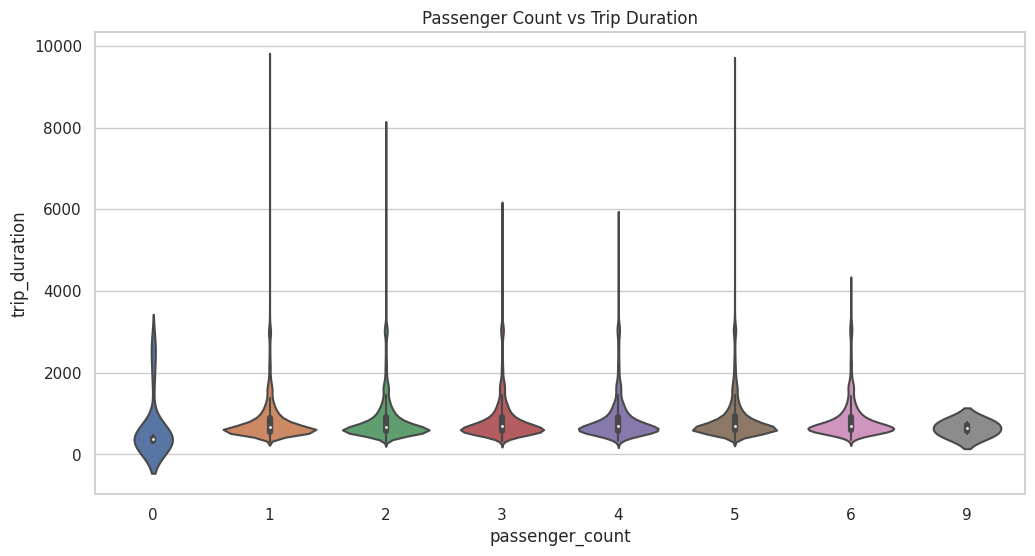

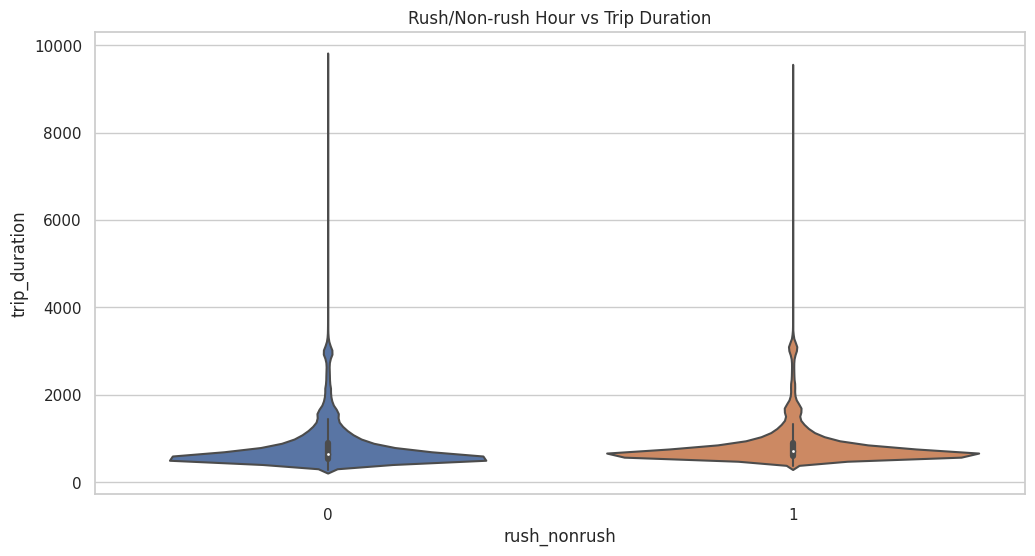

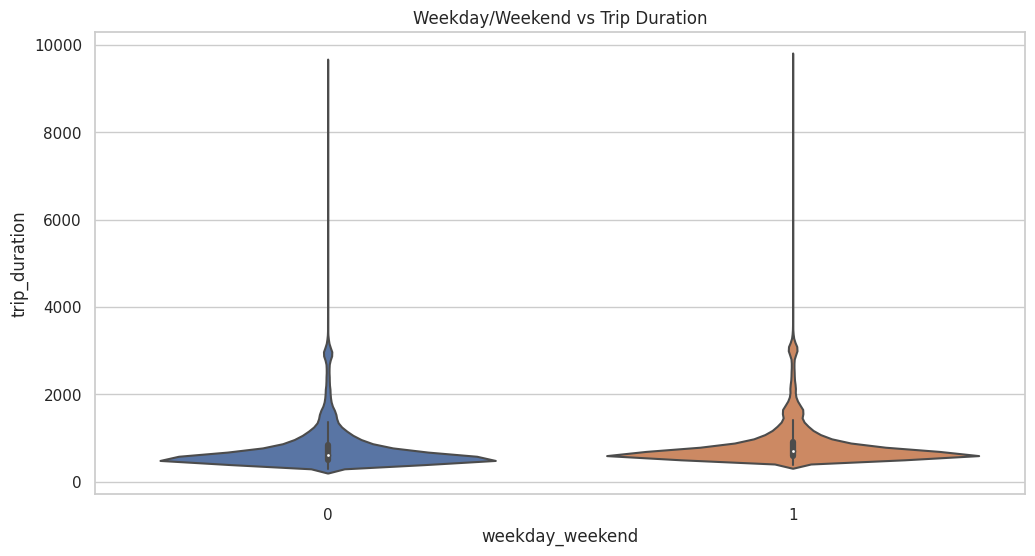

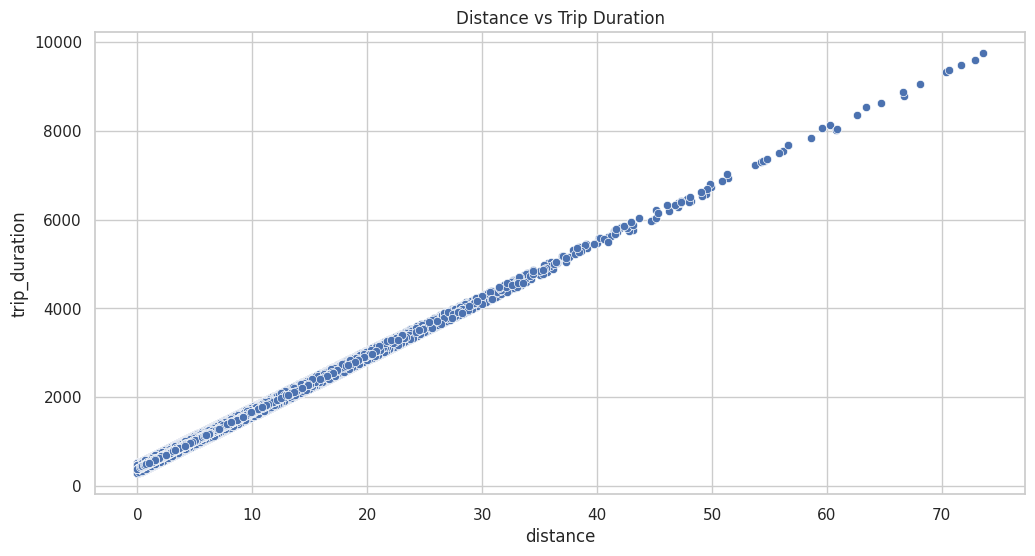

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming concatenated_df is your DataFrame

# Set the style of seaborn
sns.set(style="whitegrid")

# Plotting passenger_count against trip_duration
plt.figure(figsize=(12, 6))
sns.violinplot(x="passenger_count", y="trip_duration", data=concatenated_df)
plt.title("Passenger Count vs Trip Duration")
plt.show()

# Plotting rush_nonrush against trip_duration
plt.figure(figsize=(12, 6))
sns.violinplot(x="rush_nonrush", y="trip_duration", data=concatenated_df)
plt.title("Rush/Non-rush Hour vs Trip Duration")
plt.show()

# Plotting weekday_weekend against trip_duration
plt.figure(figsize=(12, 6))
sns.violinplot(x="weekday_weekend", y="trip_duration", data=concatenated_df)
plt.title("Weekday/Weekend vs Trip Duration")
plt.show()

# Plotting distance against trip_duration
plt.figure(figsize=(12, 6))
sns.scatterplot(x="distance", y="trip_duration", data=concatenated_df)
plt.title("Distance vs Trip Duration")
plt.show()


array([[<Axes: title={'center': 'passenger_count'}>,
        <Axes: title={'center': 'rush_nonrush'}>],
       [<Axes: title={'center': 'weekday_weekend'}>,
        <Axes: title={'center': 'distance'}>],
       [<Axes: title={'center': 'trip_duration'}>, <Axes: >]],
      dtype=object)

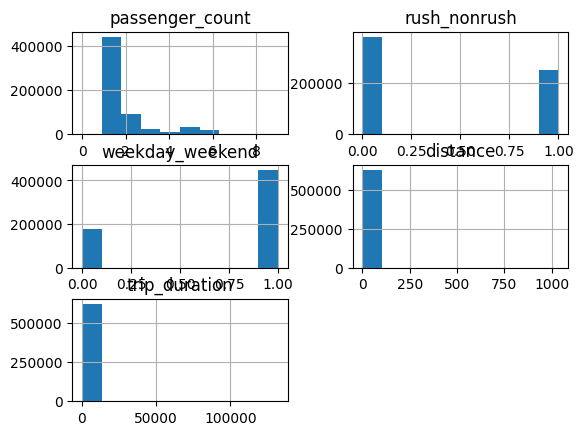

In [ ]:
concatenated_df.hist()

### 4.2 Training and testing with XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

param = {'objective': 'reg:squarederror', 'eval_metric': 'rmse','max_depth':5,'learning_rate':0.1,'subsample':0.8,'colsample_bytree':0.8,'n_estimators':100}
num_round = 10
model = xgb.train(param, dtrain, num_round)
predictions = model.predict(dtest)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')
# Menghitung RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:05:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Squared Error: 222322.12610666835
Root Mean Squared Error (RMSE): 471.51047295544595


In [ ]:
print(predictions)

[2364.9165   809.2102  1006.07104 ...  858.62006  642.12555 1404.5173 ]


In [ ]:
y_test_transformed

array([[5553.],
       [ 545.],
       [ 969.],
       ...,
       [ 532.],
       [ 255.],
       [1132.]])

In [ ]:
from sklearn.svm import LinearSVR
model = LinearSVR()
model.fit(X_scaled, y)

LinearSVR()

In [ ]:
y_pred_scaled = model.predict(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearSVR was fitted without feature names
  warnings.warn(


In [ ]:
y_pred = scaler2.inverse_transform(y_pred_scaled.reshape(-1,1))
y_test_transformed = scaler2.inverse_transform(y_test)

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_pred, y_test_transformed))
print(f"Root Mean Squared Error (RMSE): {rmse}")

In [ ]:
y_pred_scaled

In [ ]:
from sklearn.metrics import r2_score
y_pred_scaled = model.predict(X_train)

y_pred = scaler2.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_train_transformed = scaler2.inverse_transform(y_train)

r2 = r2_score(y_train_transformed, y_pred)
print(f"R-squared (R2 Score): {r2}")

In [ ]:
y_pred_scaled

In [ ]:
y_train_transformed,y_pred

In [ ]:
df_test = pd.read_csv("/kaggle/input/nyc-taxi-trip-duration/test.zip")
df_test.shape

In [ ]:
df_test = pd.read_csv("/kaggle/input/nyc-taxi-trip-duration/test.zip")
df_test['distance'] = df_test.apply(haversine_distance, axis=1)
df_test.drop(columns=['vendor_id','id','pickup_datetime','store_and_fwd_flag','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], inplace=True, axis=1)
scaled_df_test = scaler1.transform(df_test)

In [ ]:
y_pred_scaled = model.predict(scaled_df_test)

In [ ]:
y_pred_scaled.shape

In [ ]:
df_pred = pd.DataFrame(y_pred_scaled, columns=['trip_duration'])

In [ ]:
df_test = pd.read_csv("/kaggle/input/nyc-taxi-trip-duration/test.zip")

In [ ]:
concatenated_df = pd.concat([df_pred,df_test[['id']]], axis=1)

In [ ]:
concatenated_df = concatenated_df.reindex(columns=['id', 'trip_duration'])

In [ ]:
concatenated_df.to_csv('output_prediksi.csv', index=False)

### 4.3 Training and testing with GLM

In [ ]:
import statsmodels.api as sm

X = df.drop(columns=['trip_duration'])
y = df[['trip_duration']]

model = sm.GLM(y, X, family=sm.families.Gamma())
result = model.fit()

df_test = pd.read_csv("/kaggle/input/nyc-taxi-trip-duration/test.zip")

In [ ]:
df_test['distance'] = df_test.apply(haversine_distance, axis=1)
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])
df_test['rush_nonrush'] = df_test['pickup_datetime'].dt.hour.apply(lambda x: 'rush' if 7 <= x < 19 else 'nonrush')
df_test['weekday_weekend'] = df_test['pickup_datetime'].dt.dayofweek.apply(lambda x: 'weekday' if x < 5 else 'weekend')

df_encoded_test = pd.get_dummies(df_test, columns=['rush_nonrush', 'weekday_weekend'])
df_encoded_test.tail()

# Ubah ke biner
df_encoded_test['rush_nonrush'] = df_encoded_test['rush_nonrush_rush'].astype(int)
df_encoded_test['weekday_weekend'] = df_encoded_test['weekday_weekend_weekday'].astype(int)
df_encoded_test = df_encoded_test.drop(['rush_nonrush_rush', 'rush_nonrush_nonrush', 'weekday_weekend_weekday', 'weekday_weekend_weekend'], axis=1)
df_encoded_test.drop(columns=['vendor_id','id','pickup_datetime','store_and_fwd_flag','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], inplace=True, axis=1)

In [ ]:
y_pred = result.predict(df_encoded_test)
print(y_pred)

### 4.4 Training and testing with Ridge

In [ ]:
X = df.drop(columns=['trip_duration'])
y = df[['trip_duration']]


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable

# Splitting X and y into training and testing sets (using 80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

# Print the shapes of the resulting sets to verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import Ridge

# Inisialisasi model Ridge
alpha = 1.0  # Besar parameter regularisasi (gantilah sesuai kebutuhan)
ridge_model = Ridge(alpha=alpha)

# Latih model pada data latih
ridge_model.fit(X_train_scaled, y_train)

In [ ]:
# Prediksi menggunakan data uji
y_pred_ridge = ridge_model.predict(X_test_scaled)

In [ ]:
# Evaluasi model
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
print(f"RMSE (Ridge): {rmse_ridge}")

### 4.5 Training and testing with SVR

In [ ]:
X = df.drop(columns=['trip_duration'])
y = np.ravel(df[['trip_duration']])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.svm import LinearSVR
model = LinearSVR()
model.fit(X_scaled, y)

In [ ]:
df_test = pd.read_csv("/kaggle/input/nyc-taxi-trip-duration/test.zip")
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])
df_test['rush_nonrush'] = df_test['pickup_datetime'].dt.hour.apply(lambda x: 'rush' if 7 <= x < 19 else 'nonrush')
df_test['weekday_weekend'] = df_test['pickup_datetime'].dt.dayofweek.apply(lambda x: 'weekday' if x < 5 else 'weekend')

df_encoded_test = pd.get_dummies(df_test, columns=['rush_nonrush', 'weekday_weekend'])

# Ubah ke biner
df_encoded_test['rush_nonrush'] = df_encoded_test['rush_nonrush_rush'].astype(int)
df_encoded_test['weekday_weekend'] = df_encoded_test['weekday_weekend_weekday'].astype(int)
df_encoded_test = df_encoded_test.drop(['rush_nonrush_rush', 'rush_nonrush_nonrush', 'weekday_weekend_weekday', 'weekday_weekend_weekend'], axis=1)
df_encoded_test.drop(columns=['vendor_id','id','pickup_datetime','store_and_fwd_flag','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], inplace=True, axis=1)
df_encoded_test['distance'] = df_test.apply(haversine_distance, axis=1)

In [ ]:
model_columns = ['passenger_count','rush_nonrush','weekday_weekend','distance']
df_encoded_test = df_encoded_test[model_columns]

In [ ]:
X_test_scaled = scaler.transform(df_encoded_test)
y_pred = model.predict(X_test_scaled)
df_pred = pd.DataFrame(y_pred, columns=['trip_duration'])
df_test = pd.read_csv("/kaggle/input/nyc-taxi-trip-duration/test.zip")